In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, gen_instance

torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
T = 5
device = 'cpu'

In [2]:
def train_instance(n, model, optimizer, n_ants):
    model.train()
    demands = gen_instance(n, device)
    pyg_data = gen_pyg_data(demands, device)
    heu_vec = model(pyg_data)
    heu_mat = heu_vec.reshape((n+1, n+1)) + EPS
    aco = ACO(
        demand=demands,
        n_ants=n_ants,
        heuristic=heu_mat,
        device=device
        )
    
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(n, model, n_ants):
    model.eval()
    demands = gen_instance(n, device)
    pyg_data = gen_pyg_data(demands, device)
    heu_vec = model(pyg_data)
    heu_mat = heu_vec.reshape((n+1, n+1)) + EPS
    aco = ACO(
        demand=demands,
        n_ants=n_ants,
        heuristic=heu_mat,
        device=device
        )
    costs, log_probs = aco.sample()
    aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = -aco.best_fitness
    return baseline.item(), best_sample_cost.item(), best_aco_cost.item()

In [3]:
def train_epoch(n_node,
                n_ants, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        train_instance(n_node, net, optimizer, n_ants)


@torch.no_grad()
def validation(n_node, n_ants, epoch, net, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    n_val = 100
    for _ in range(n_val):
        bl, sample_best, aco_best = infer_instance(n_node, net, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    return avg_bl, avg_sample_best, avg_aco_best

In [6]:
def train(n_node, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_node, n_ants, -1, net, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    val_best = 1e10
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_best, avg_aco_best = validation(n_node, n_ants, epoch, net, animator)
        val_results.append((avg_bl, avg_best, avg_aco_best))
        if avg_aco_best < val_best:
            val_best = avg_aco_best
            torch.save(net.state_dict(), f'../pretrained/bpp/bpp{n_node}.pt')
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
    

## Learn heuristic for BPP120: 

total training duration: 89.71171736717224
epoch -1: (-0.18337705628980777, -0.18589751340897936, -0.18798193825032836)
epoch 0: (-0.8963365986822392, -0.9136231126128608, -0.9218189613361958)
epoch 1: (-0.9273510126496883, -0.9418272748111812, -0.9468318368315312)
epoch 2: (-0.932483892757732, -0.9457785395984915, -0.9507360886221088)
epoch 3: (-0.9349467789661189, -0.9478074390612083, -0.9515430420061141)
epoch 4: (-0.935247632492922, -0.9472265483895573, -0.9519719415808998)


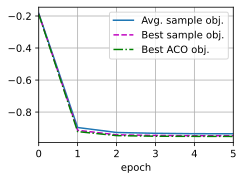

In [8]:
n_node, n_ants = 120, 20
steps_per_epoch = 64
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)